In [1]:
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from pytransform3d import rotations as pr
from pytransform3d import transformations as pt
from pytransform3d.transform_manager import TransformManager

%matplotlib widget

In [2]:
# linalg utils
def e2h(points):
    if points.ndim == 1:
        points = np.append(points, 1)
    else:
        ones_column = np.ones((points.shape[0], 1))
        points = np.hstack((points, ones_column))
    
    return points

def h2e(points):
    if points.ndim == 1:
        return points[:-1] / points[-1]
    else:
        return points[:, :-1] / points[:, -1][:, np.newaxis]


def rotation (axis, angle, degrees=False):
    r = R.from_euler(axis, angle, degrees=degrees).as_matrix()
    return np.vstack((np.hstack((r, np.zeros((3, 1)))), np.array([0, 0, 0, 1])))

def translation(x, y, z):
    return np.array([
        [1, 0, 0, x],
        [0, 1, 0, y],
        [0, 0, 1, z],
        [0, 0, 0, 1]
    ])

def translationv(vector):
    return translation(vector[0], vector[1], vector[2])

In [3]:
# draw a vector with a base
def draw_vector(vector, ax, start = np.array([0, 0, 0]), color = "b"):
    ax.quiver(*start, *vector, color=color, arrow_length_ratio=0.2)
    return start + vector

def draw_point(position, ax, color = "r"):
    ax.scatter(*position, marker='o', c=color)

In [4]:
# robot consts


TORSO_TO_ROBOT = np.array([-0.0413, 0.0, -0.12842])
ROBOT_TO_NECK = np.array([0.0, 0.0, 0.2115])
ROBOT_TO_LEFT_PELVIS = np.array([0.0, 0.05, 0.0])
ROBOT_TO_RIGHT_PELVIS = np.array([0.0, -0.05, 0.0])
HIP_TO_KNEE = np.array([0.0, 0.0, -0.1])
KNEE_TO_ANKLE = np.array([0.0, 0.0, -0.1029])
ANKLE_TO_SOLE = np.array([0.0, 0.0, -0.04519])
ROBOT_TO_LEFT_SHOULDER = np.array([0.0, 0.098, 0.185])
ROBOT_TO_RIGHT_SHOULDER = np.array([0.0, -0.098, 0.185])
LEFT_SHOULDER_TO_LEFT_ELBOW = np.array([0.105, 0.015, 0.0])
RIGHT_SHOULDER_TO_RIGHT_ELBOW = np.array([0.105, -0.015, 0.0])
ELBOW_TO_WRIST = np.array([0.05595, 0.0, 0.0])
NECK_TO_TOP_CAMERA = np.array([0.05871, 0.0, 0.06364])
NECK_TO_BOTTOM_CAMERA = np.array([0.05071, 0.0, 0.01774])

def draw_base_skeleton(ax):
    draw_point(np.array([0,0,0]), ax)
    draw_vector(TORSO_TO_ROBOT, ax, start=np.array([0, 0, 0]), color="r")
    draw_vector(ROBOT_TO_NECK, ax, start=TORSO_TO_ROBOT)
    left_hip = draw_vector(ROBOT_TO_LEFT_PELVIS, ax, start=TORSO_TO_ROBOT)
    right_hip = draw_vector(ROBOT_TO_RIGHT_PELVIS, ax, start=TORSO_TO_ROBOT)
    left_knee = draw_vector(HIP_TO_KNEE, ax, start=left_hip)
    right_knee = draw_vector(HIP_TO_KNEE, ax, start=right_hip)
    left_ankle = draw_vector(KNEE_TO_ANKLE, ax, start=left_knee)
    right_ankle = draw_vector(KNEE_TO_ANKLE, ax, start=right_knee)

def frame_unit_vectors(rotation, frame = np.array([[0.1, 0, 0], [0, 0.1, 0], [0, 0, 0.1]])):
    return h2e((rotation @ e2h(frame).T).T)

# frame_unit_vectors(rotation("x", -np.pi / 4))

def draw_axis(ax, position, frame = np.array([[0.1, 0, 0], [0, 0.1, 0], [0, 0, 0.1]]), label =""):
    ax.quiver(*position, *frame[0], color="r", arrow_length_ratio=0.2)
    ax.quiver(*position, *frame[1], color="g", arrow_length_ratio=0.2)
    ax.quiver(*position, *frame[2], color="b", arrow_length_ratio=0.2)
    ax.text(*position, f"{label}")

[ 0.02244612  0.         -0.18      ]
[-0.02244612 -0.          0.18      ]
left_foot_roll_in_pelvis: -0.0
left_foot_pitch_in_pelvis: -0.12406025549167862
0.17999999999999997


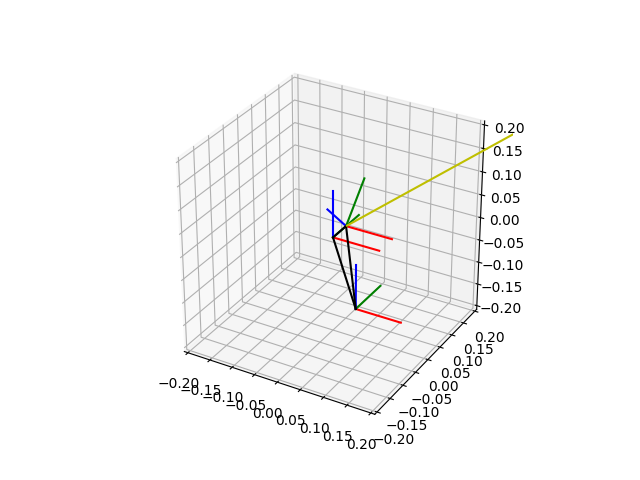

In [5]:
# parameters
# expected pitch = -0.50059056
forward = 0.02244612
left = 0
turn_left = 0.0
walk_hip_height = 0.18
foot_lift = 0

def isometry3 (rotation, translation):
    return rotation @ translationv(translation)


tm = TransformManager()

# left foot to torso
hip_to_robot = ROBOT_TO_LEFT_PELVIS
foot_translation = np.array([forward, left, -walk_hip_height + foot_lift])
print(foot_translation)

left_foot_to_torso = pt.transform_from(R.from_euler("z", turn_left).as_matrix(), ROBOT_TO_LEFT_PELVIS + foot_translation)
tm.add_transform("LFoot", "robot", left_foot_to_torso)

torso_to_left_pelvis = isometry3(rotation("x", -np.pi / 4), -ROBOT_TO_LEFT_PELVIS)
tm.add_transform("robot", "LHip", torso_to_left_pelvis)



left_foot_to_left_pelvis = torso_to_left_pelvis @ left_foot_to_torso
tm.add_transform("LFoot", "LHip", left_foot_to_left_pelvis)

vector = np.linalg.inv(left_foot_to_left_pelvis)[:-1,-1]
left_foot_roll_in_pelvis = np.arctan2(vector[1], vector[2])
left_foot_pitch_in_pelvis = np.arctan2(vector[0], np.sqrt(vector[1] ** 2 + vector[2] ** 2))
print(vector)
print("left_foot_roll_in_pelvis:", left_foot_roll_in_pelvis)
print("left_foot_pitch_in_pelvis:", left_foot_pitch_in_pelvis)
print(np.sqrt(vector[1] ** 2 + vector[2] ** 2))



fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
# draw_vector(vector, ax=ax, start=foot_translation + ROBOT_TO_LEFT_PELVIS)
pelv_vec = np.array([-0.6909422, 0.33824071, -0.63889912])
draw_vector(pelv_vec * -1, ax=ax, start=ROBOT_TO_LEFT_PELVIS, color="y")
# draw_vector(np.array([vector[0], vector[1], np.sqrt(vector[1] ** 2 + vector[2] ** 2)]), ax=ax, start=foot_translation + ROBOT_TO_LEFT_PELVIS, color="r")

ax = tm.plot_frames_in("robot", s=0.1, ax=ax, show_name=False)
ax = tm.plot_connections_in("robot", ax=ax)
ax.set_xlim(-0.2, 0.2)
ax.set_ylim(-0.2, 0.2)
ax.set_zlim(-0.2, 0.2)
plt.gca().set_aspect("equal")
plt.show()

[ 0.92387953 -0.38268343  0.          0.        ]
[[ 1.         -0.          0.        ]
 [ 0.          0.70710678  0.70710678]
 [-0.         -0.70710678  0.70710678]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
res [[ 0.99231439  0.          0.12374227  0.        ]
 [ 0.          1.          0.          0.        ]
 [-0.12374227  0.          0.99231439  0.        ]
 [ 0.          0.          0.          1.        ]]
LHR: [0. 1. 0.]
[ 0.          0.70710678 -0.70710678]
total: 0.0


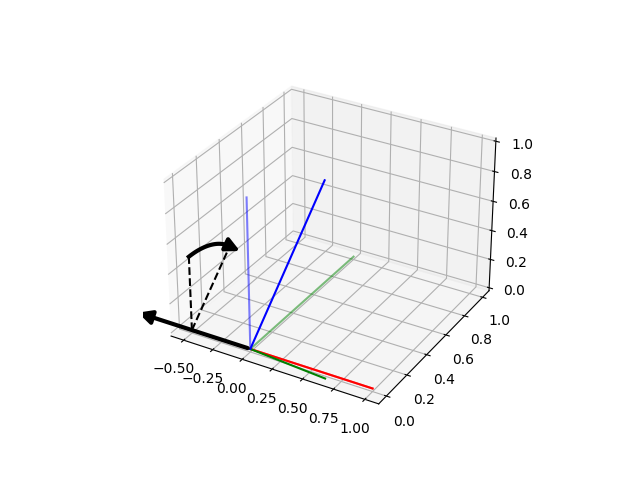

In [6]:
from pytransform3d.rotations import plot_basis, q_prod_vector, plot_axis_angle, axis_angle_from_matrix, matrix_from_axis_angle, matrix_from_quaternion, euler_from_matrix
from pytransform3d.transformations import transform_from, concat, pq_from_transform
fig = plt.figure()

Rroll = R.from_euler("x", -left_foot_roll_in_pelvis).as_matrix()
Rpitch = R.from_euler("y", left_foot_pitch_in_pelvis).as_matrix()

def plot_rot(rotation):
    ax = fig.add_subplot(111, projection="3d")
    for fraction in np.linspace(0, 1, 2):
        a = axis_angle_from_matrix(rotation)
        a[-1] = fraction * a[-1]
        b = matrix_from_axis_angle(a)
        plot_basis(ax, b, alpha=min(fraction + 0.5, 1))
    plot_axis_angle(ax, axis_angle_from_matrix(rotation))

quat = pq_from_transform(left_foot_to_left_pelvis)[3:]
left_foot_to_left_pelvis_rot = matrix_from_quaternion(quat)
print(quat)
print(left_foot_to_left_pelvis_rot)
rot = transform_from(left_foot_to_left_pelvis_rot, [0, 0, 0])


inner_rot = transform_from(Rroll, [0, 0, 0]).T
print(inner_rot)
inner_rot = concat(inner_rot, transform_from(Rpitch, [0, 0, 0]).T)
print("res", inner_rot)

y = np.array([0, 1, 0, 1])
res = (inner_rot.T @ y)[:3]
print("LHR:", res)

left_hip_rotation_c1 = q_prod_vector(quat, res)
print(left_hip_rotation_c1)
left_hip_yaw_pitch = -1.0 * np.arctan2((-1.0 * left_hip_rotation_c1[0]), left_hip_rotation_c1[1])
print("total:", left_hip_yaw_pitch)


plot_rot(rot[:-1, :-1])
ax.view_init(azim=105, elev=12)
plt.show()

In [7]:
# # control
# hip_height = 0.185
# foot_height = 0.03 # in meters from the ground, below the hip 
# forward = 0.04 # the ankle position in meters forward from the hip position, (x direction)
# left = 0 # the displacement in meters of the foot while steping sideways, (y direction)

# robot_to_target = np.array([forward, left, 0])
# robot_to_torso = np.array([0, 0, hip_height])
# torso_to_hip = np.array([0, 0.05, 0])

# hip_to_knee = np.array([0, 0, 0.1])
# knee_to_ankle = np.array([0, 0, 0.1029])

# torso_to_foot = torso_to_hip + hip_to_knee+ knee_to_ankle + robot_to_target

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(robot_to_torso[0], robot_to_torso[1], robot_to_torso[2])
# draw_vector(robot_to_torso, torso_to_hip, ax)
# draw_vector(robot_to_torso + torso_to_hip, hip_to_knee, ax)
# draw_vector(robot_to_torso + torso_to_hip + hip_to_knee, knee_to_ankle, ax)
# draw_vector(robot_to_torso, torso_to_foot, ax, "r")
# draw_vector(robot_to_torso, (torso_to_hip * torso_to_foot) , ax, "g")


# thigh_joint = draw_joint(robot_to_torso + torso_to_hip, [0 , 1.0243430016070365, 0], 0.1, "g")
# knee_joint = draw_joint(thigh_joint, [0, 1.0243430016070365 -1.0234344772825044, 0], 0.1029, "y")

# ax.set_xlim([-.15, 0.15])
# ax.set_ylim([-.15, 0.15])
# ax.set_zlim([0.3, 0])
# plt.show()